# Sample-level embeddings

Held-out intermediates are projected into PCA space.

In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from sklearn.decomposition import PCA

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
sns.set_palette('colorblind')

In [2]:
RESULTS_FILE = "out/results/GAT_2024-05-23-16-24-07_results.h5ad"  # No-Graph model
# RESULTS_FILE = "out/results/GAT_2024-05-23-16-23-45_results.h5ad"  # GAT model
FOLD = 4
ddata = ad.read_h5ad(RESULTS_FILE.replace(".h5ad", f"_donor_{FOLD}.h5ad"))
ddata.uns["perf_test"]

{'accuracy': np.float64(0.7777777777777778),
 'f1': np.float64(0.8000000000000002),
 'precision': np.float64(0.8),
 'recall': np.float64(0.8),
 'roc_auc': np.float64(0.8999999999999999)}

In [3]:
wang_labels = []
for i, donor in enumerate(ddata.obs_names):
    dddata = ddata[ddata.obs_names == donor].copy().obs
    cogdx = dddata["cogdx"].values[0]
    braaksc = dddata["braaksc"].values[0]
    ceradsc = dddata["ceradsc"].values[0]
    if cogdx == 4 and braaksc >= 4 and ceradsc <= 2:
        wang_labels.append("AD")
    elif cogdx == 1 and braaksc <= 3 and ceradsc >= 3:
        wang_labels.append("CT")
    else:
        wang_labels.append("Other")
ddata.obs["wang_label"] = wang_labels
ddata.obs["Disease State"] = ddata.obs["wang_label"].map(
    {"AD": "AD", "CT": "Healthy", "Other": "Intermediate"}
)

ddata.obs["reagan_desc"] = ddata.obs["niareagansc"].map({4: "No AD", 3: "Low", 2: "Int", 1: "High"})
ddata.obs["reagan_dich"] = ddata.obs["niareagansc"].map({4: 0, 3: 0, 2: 1, 1: 1})

ddata.obs["cogdx_desc"] = ddata.obs["cogdx"].map({1: "NCI", 2: "MCI", 3: "MCI+", 4: "AD", 5: "AD+", 6: "Other"})
ddata.obs["cogdx_dich"] = ddata.obs["cogdx"].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0})

ddata.obs["y_true"] = ddata.obs["wang_label"].map({"AD": 1, "CT": 0, "Other": 2})
ddata.obs["acc"] = 1 - np.abs(ddata.obs["cogdx_dich"] - ddata.obs["y_pred"])

ddata.obs["sex"] = ddata.obs["msex"].map({0: "Female", 1: "Male"})

In [4]:
# add the polygenic risk scores
prss = pd.read_csv("data/PRS_FinnGen_by_projid.csv", index_col=0)
prss.index = prss.index.astype(str)

donors_missing_prs = [donor for donor in ddata.obs.index.unique() if donor not in prss.index]
print(f"Donors missing PRS ({len(donors_missing_prs)}): {donors_missing_prs}")

label_counts = {
    "AD": 0,
    "CT": 0,
    "Other": 0,
}
for donor in donors_missing_prs:
    donor_adata = ddata[ddata.obs.index == donor]
    label = donor_adata.obs["wang_label"].unique()[0]
    label_counts[label] += 1
    
print("Label counts for donors missing PRS:")
for label, count in label_counts.items():
    print(f"{label}: {count}")
    
# Drop them from adata for now:
ddata = ddata[~ddata.obs.index.isin(donors_missing_prs)].copy()

# Add PRS to adata
ddata.obs["PRS"] = prss.loc[ddata.obs.index]
ddata.obs["PRS_z"] = (ddata.obs["PRS"] - ddata.obs["PRS"].mean()) / ddata.obs["PRS"].std()

Donors missing PRS (27): ['1211411', '11630705', '20201927', '20875195', '22776575', '23690880', '34726040', '37030589', '37436329', '48023497', '50105699', '50109477', '50301099', '50301125', '50302266', '50500550', '52764842', '61827429', '62404688', '68539908', '70816595', '74284255', '78452313', '84417209', '86934089', '90780976', '96095092']
Label counts for donors missing PRS:
AD: 5
CT: 10
Other: 12


In [5]:
ddata

AnnData object with n_obs × n_vars = 312 × 128
    obs: 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl', 'cancer_bl', 'diabetes_sr_rx_bl', 'headinjrloc_bl', 'thyroid_bl', 'chf_bl

In [6]:
ddata_noint = ddata[ddata.obs["cv_set"] != "heldout"].copy()

pca = PCA(n_components=50).fit(ddata_noint.X)
x_noint_pca = pca.transform(ddata_noint.X)
x_full_pca = pca.transform(ddata.X)

ddata.obs["PCA1"] = x_full_pca[:, 0]
ddata.obs["PCA2"] = x_full_pca[:, 1]
ddata.obs["PCA3"] = x_full_pca[:, 2]
ddata.obs["PCA4"] = x_full_pca[:, 3]

# Slice again, because we added new columns
ddata_noint = ddata[ddata.obs["cv_set"] != "heldout"].copy()

Text(0, 0.5, 'PRS_z')

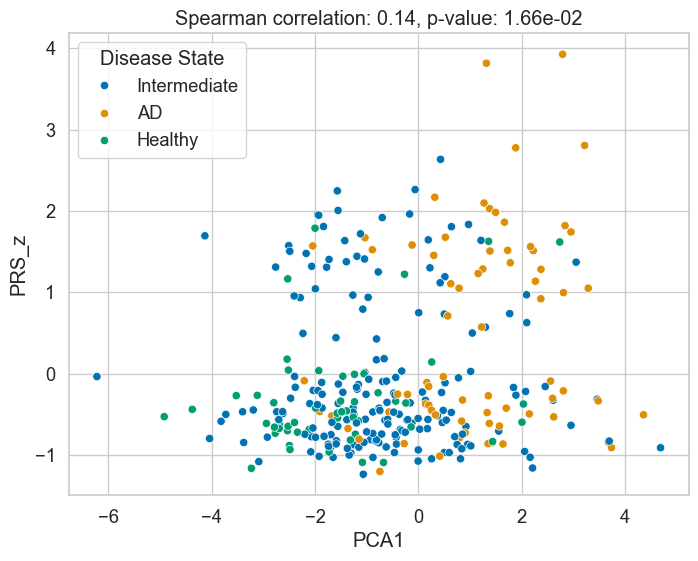

In [7]:
# scatter PCA1 vs PRS_z

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ddata.obs, x="PCA1", y="PRS_z", hue="Disease State")

# correlation
corr, pval = spearmanr(ddata.obs["PCA1"], ddata.obs["PRS_z"])
plt.title(f"Spearman correlation: {corr:.2f}, p-value: {pval:.2e}")
plt.xlabel("PCA1")
plt.ylabel("PRS_z")



Correlation between PCA1 and age_death: SignificanceResult(statistic=np.float64(0.4063956040848526), pvalue=np.float64(2.822253468753229e-06))


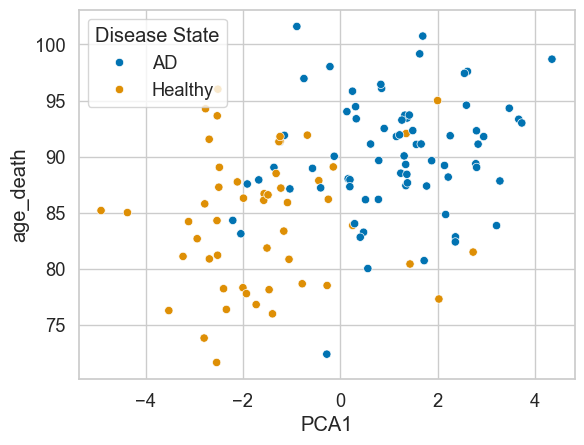

In [8]:
ddata.obs

# age_death
# sex
# apoe_genotype
# race
# spanish

# color by all these

sns.scatterplot(data=ddata_noint.obs, x="PCA1", y="age_death", hue="Disease State")
print("Correlation between PCA1 and age_death:", spearmanr(ddata_noint.obs["PCA1"], ddata_noint.obs["age_death"]))

In [9]:
ddata.obs["wang_label"]

projid
3713990     Other
3889845     Other
6804844     Other
7253015        AD
7265221        AD
            ...  
94144536    Other
94430339    Other
95491648       CT
95919181    Other
98953007       AD
Name: wang_label, Length: 312, dtype: object

In [22]:
-2.3330 / -0.9076

2.570515645658881

In [21]:
# we will use statsmodels to fit a linear model to investivate the relationship between PCA1 and age_death and sex

import statsmodels.formula.api as smf

model = smf.ols("PCA1 ~ age_death + C(wang_label) + C(sex)", data=ddata_noint.obs).fit()
# model = smf.ols("PCA1 ~ age_death * C(sex)", data=ddata_noint.obs).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   PCA1   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     38.85
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           1.29e-17
Time:                        23:20:51   Log-Likelihood:                -218.46
No. Observations:                 124   AIC:                             444.9
Df Residuals:                     120   BIC:                             456.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.2743    

In [10]:
# we will use statsmodels to fit a linear model to investivate the relationship between PCA1 and age_death and sex

import statsmodels.formula.api as smf

model = smf.ols("PCA1 ~ age_death * C(wang_label) + C(sex) * C(wang_label)", data=ddata_noint.obs).fit()
# model = smf.ols("PCA1 ~ age_death * C(sex)", data=ddata_noint.obs).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   PCA1   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     23.16
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           3.80e-16
Time:                        23:19:07   Log-Likelihood:                -218.15
No. Observations:                 124   AIC:                             448.3
Df Residuals:                     118   BIC:                             465.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [11]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame
# Create a numerical version of your label (e.g., CT=0, AD=1)
le = LabelEncoder()
ddata_noint.obs['wang_label_encoded'] = le.fit_transform(ddata_noint.obs['wang_label'])

# --- Build the Logistic Regression Model ---
# Notice we use smf.logit instead of smf.ols
logit_model = smf.logit(formula="wang_label_encoded ~ C(sex)", data=ddata_noint.obs).fit()

# Print the summary
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.666889
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:     wang_label_encoded   No. Observations:                  124
Model:                          Logit   Df Residuals:                      122
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                 0.01541
Time:                        23:19:07   Log-Likelihood:                -82.694
converged:                       True   LL-Null:                       -83.988
Covariance Type:            nonrobust   LLR p-value:                    0.1077
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6286      0.253     -2.487      0.013      -1.124      -0.133
C(sex)[T.Male]   

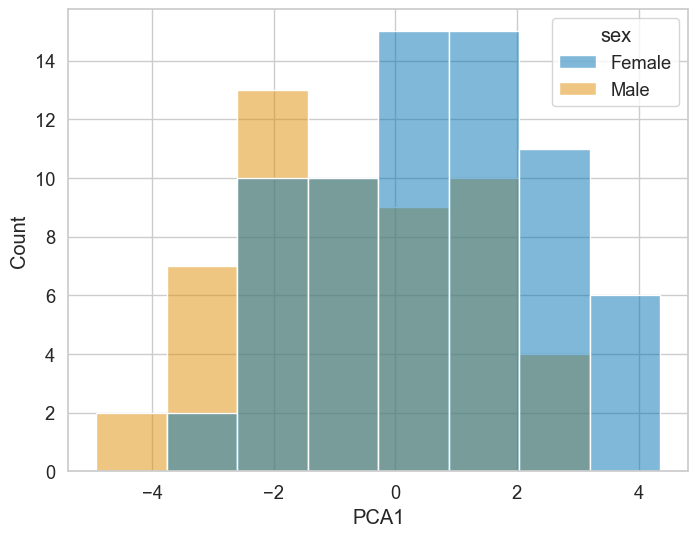

In [12]:
# same for sex (histogram)
plt.figure(figsize=(8, 6))
sns.histplot(data=ddata_noint.obs, x="PCA1", hue="sex")
plt.show()

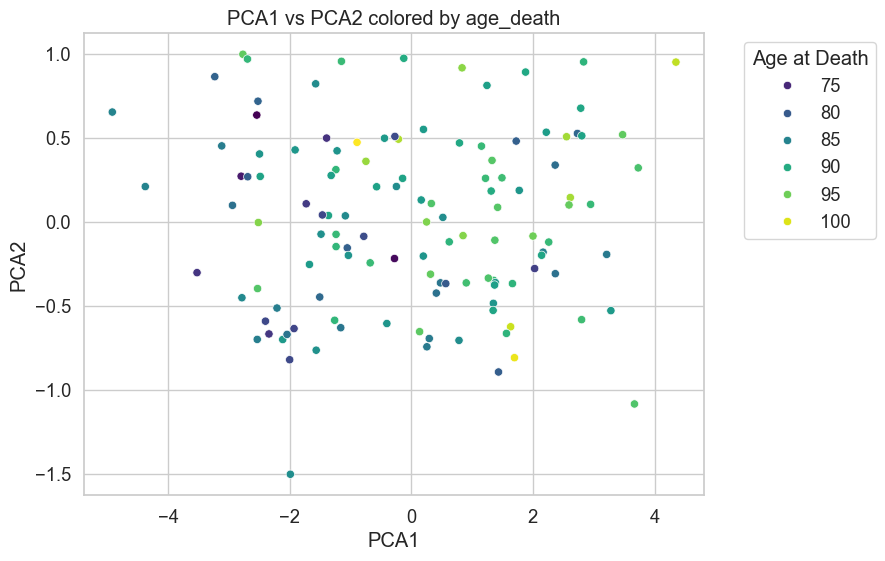

In [13]:
# scatter PCA1 vs PCA2 and color by age_death
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ddata_noint.obs, x="PCA1", y="PCA2", hue="age_death", palette="viridis")
plt.title("PCA1 vs PCA2 colored by age_death")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Age at Death", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


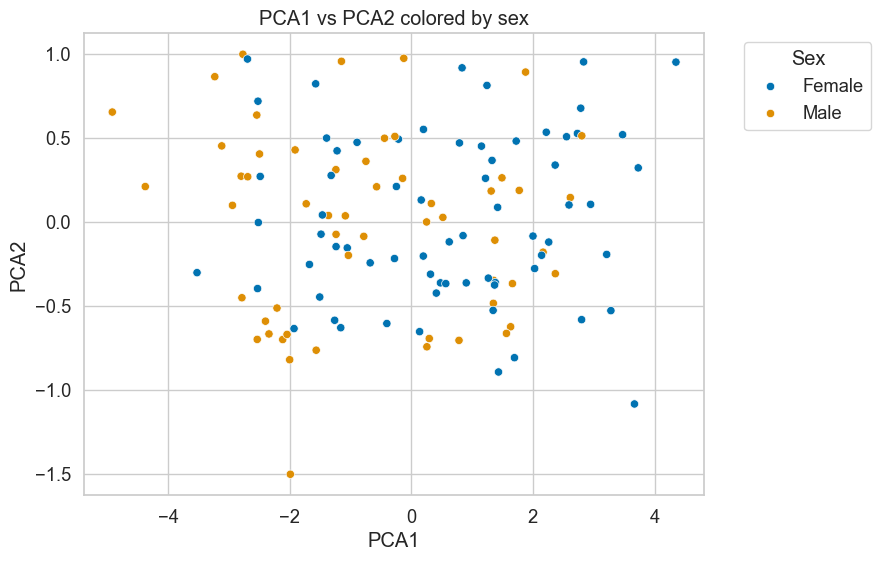

In [14]:
# scatter PCA1 vs PCA2 and color by age_death
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ddata_noint.obs, x="PCA1", y="PCA2", hue="sex")
plt.title("PCA1 vs PCA2 colored by sex")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Sex", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


(0.0, 25.0)

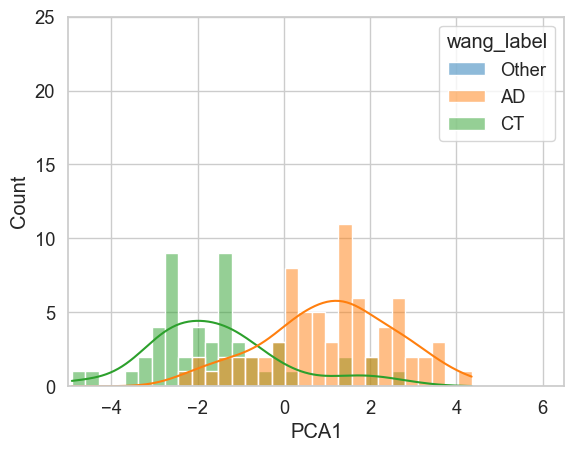

In [15]:
sns.histplot(ddata_noint.obs, x="PCA1", hue="wang_label", hue_order=["Other", "AD", "CT"], bins=30, palette="tab10", kde=True, common_norm=False)
plt.xlim(-5, 6.5)
plt.ylim(0, 25)

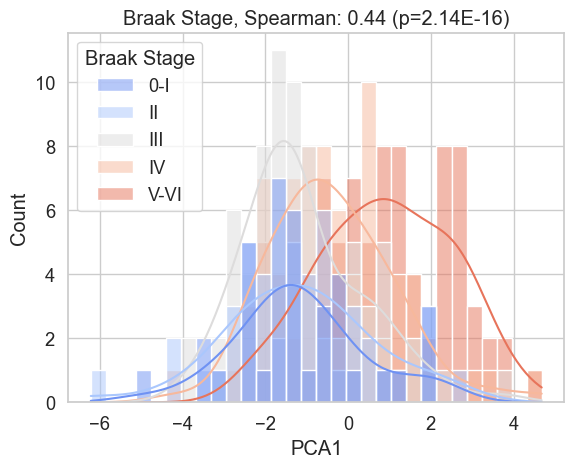

In [16]:
# Group Braak stages
ddata.obs["Braak Stage"] = ddata.obs["braaksc"].map(
    {0: "0-I", 1: "0-I", 2: "II", 3: "III", 4: "IV", 5: "V-VI", 6: "V-VI"})

sp = spearmanr(ddata.obs["PCA1"], ddata.obs["Braak Stage"])
plt.figure()
sns.histplot(ddata.obs, x="PCA1", hue="Braak Stage", bins=30, kde=True, common_norm=False, 
             palette="coolwarm",
             hue_order=["0-I", "II",  "III", "IV", "V-VI"])
plt.title(f"Braak Stage, Spearman: {sp.correlation:.2f} (p={sp.pvalue:.2E})")
plt.show()

<Axes: ylabel='Frequency'>

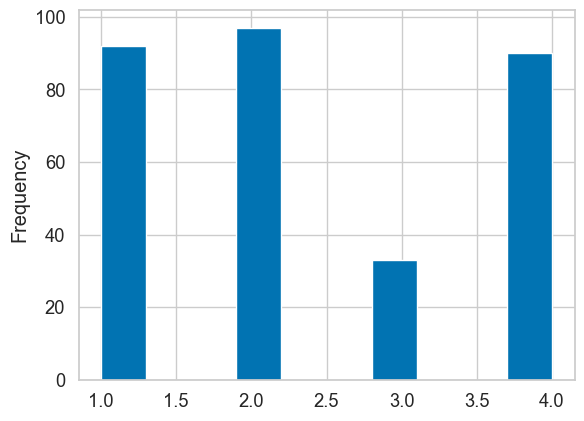

In [17]:
ddata.obs["ceradsc"].plot(kind="hist")

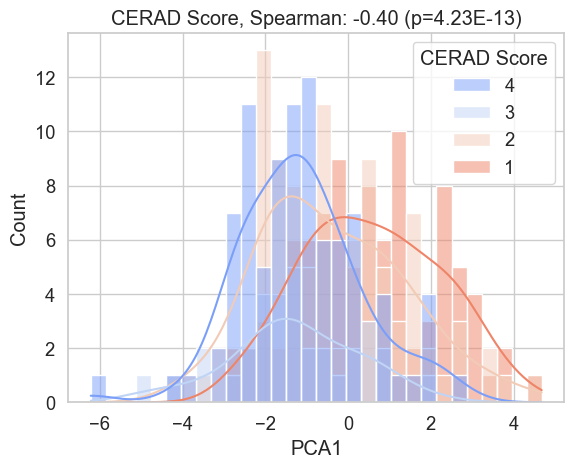

In [18]:
ddata.obs["CERAD Score"] = ddata.obs["ceradsc"].map({0: "0", 1: "1", 2: "2", 3: "3", 4: "4"})

sp = spearmanr(ddata.obs["PCA1"], ddata.obs["CERAD Score"])
plt.figure()
sns.histplot(ddata.obs, x="PCA1", hue="CERAD Score", bins=30, kde=True, common_norm=False, 
             palette="coolwarm", hue_order=["4", "3", "2", "1"])
plt.title(f"CERAD Score, Spearman: {sp.correlation:.2f} (p={sp.pvalue:.2E})")
plt.show()

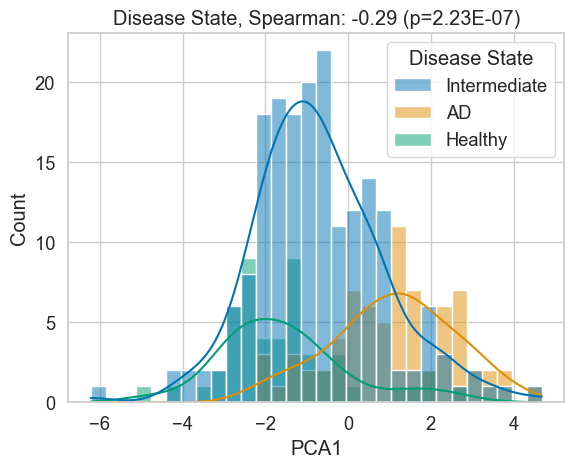

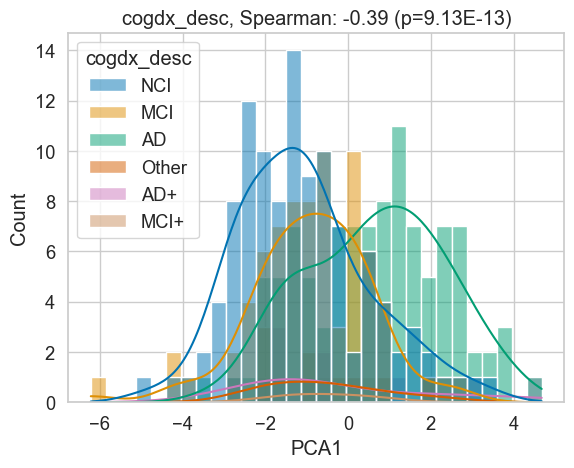

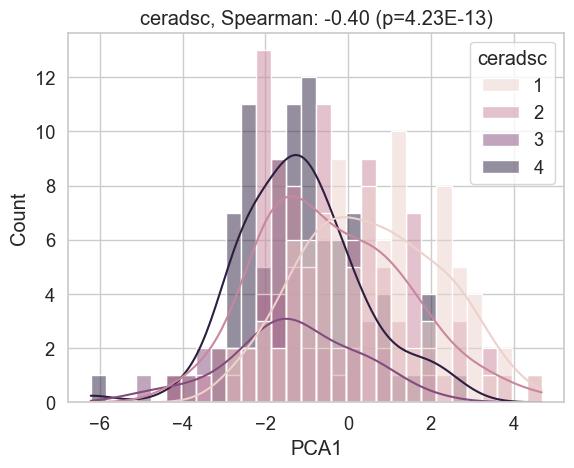

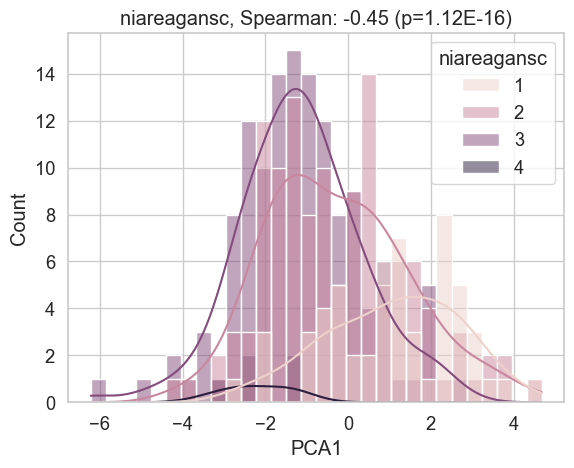

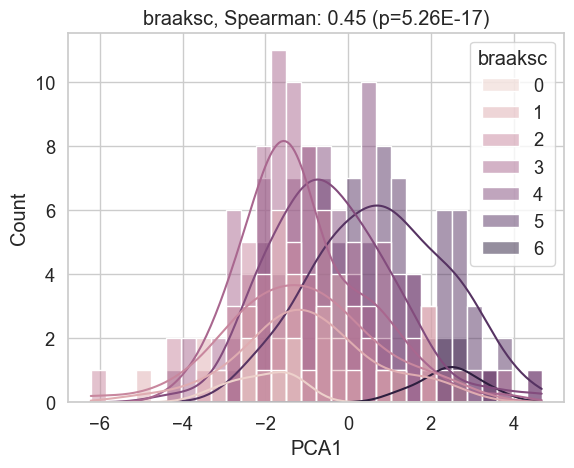

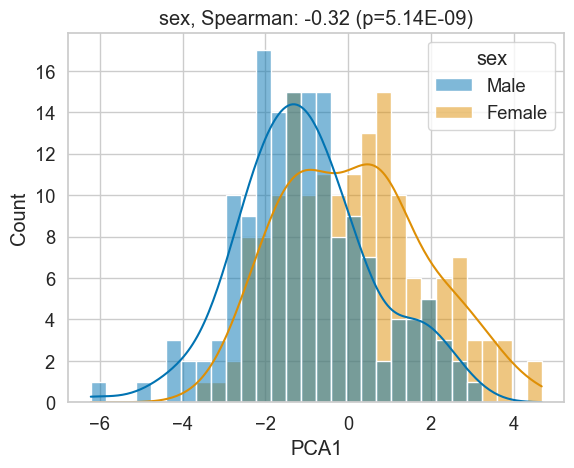

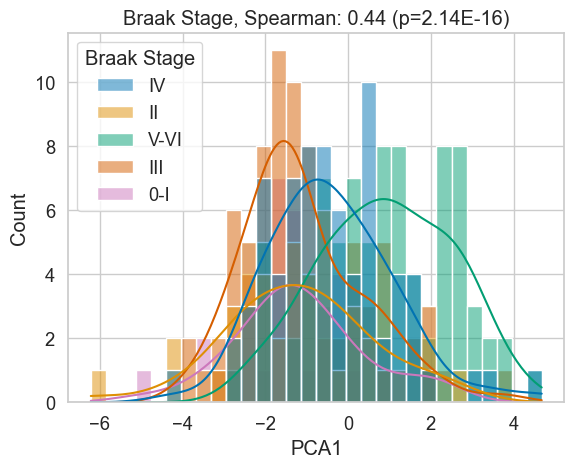

In [19]:

for col in ["Disease State", "cogdx_desc", "ceradsc", "niareagansc", "braaksc", "sex", "Braak Stage"]:
    sp = spearmanr(ddata.obs["PCA1"], ddata.obs[col])
    plt.figure()
    sns.histplot(ddata.obs, x="PCA1", hue=col, bins=30, kde=True, common_norm=False)
    plt.title(f"{col}, Spearman: {sp.correlation:.2f} (p={sp.pvalue:.2E})")
    plt.show()

In [20]:
# Plot PCA and UMAP of just the train and test data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata_noint.obs, x="PCA1", y="PCA2", 
                hue="wang_label", hue_order=["CT", "AD"], s=MARKER_SIZE, palette="tab10")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata_noint.obs, x="UMAP1", y="UMAP2", 
                hue="wang_label", hue_order=["CT", "AD"], s=MARKER_SIZE, palette="tab10")
plt.show()

NameError: name 'MARKER_SIZE' is not defined

<Figure size 1200x600 with 0 Axes>

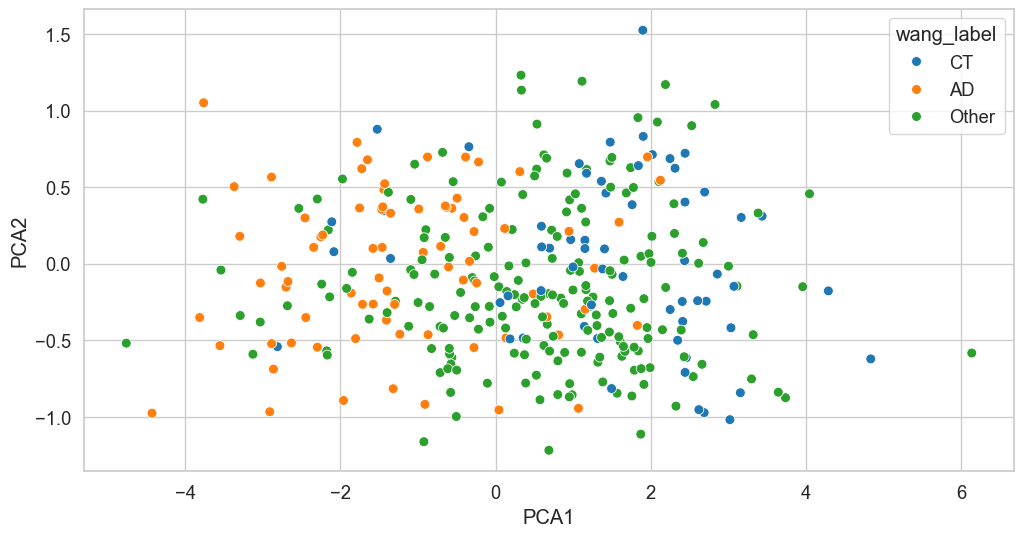

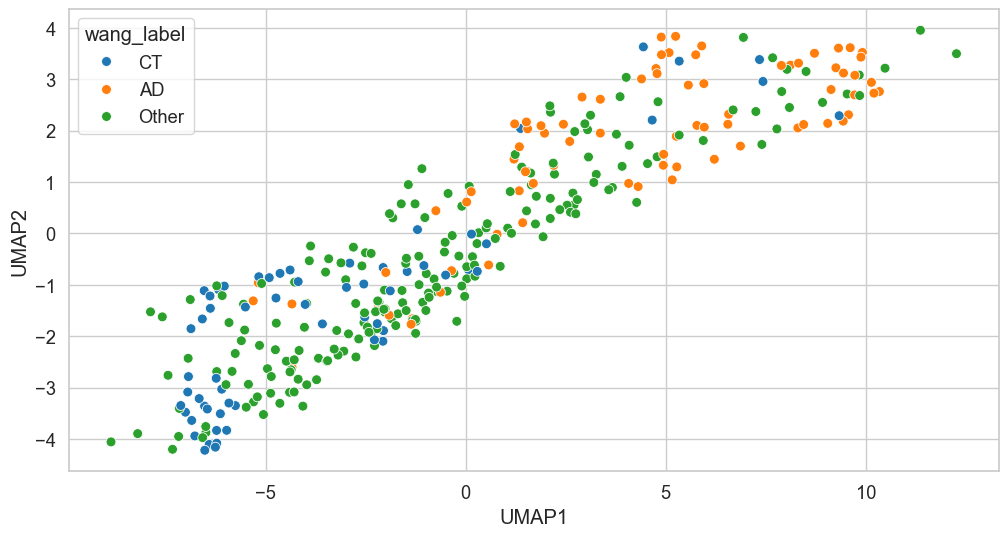

In [ ]:
# Plot PCA and UMAP of all data (by projecting the heldout data into the PCA/UMAP space)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="PCA1", y="PCA2", hue="wang_label", s=MARKER_SIZE, palette="tab10", hue_order=["CT", "AD", "Other"])
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="wang_label", s=MARKER_SIZE, palette="tab10", hue_order=["CT", "AD", "Other"])
plt.show()

In [ ]:
ddata.obs.columns

Index(['study', 'scaled_to', 'agreeableness', 'conscientiousness',
       'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12',
       'openness', 'neuroticism_48',
       ...
       'UMAP1', 'UMAP2', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'UMAP1D', 'cogdx_num',
       'extreme_case', 'y_pred_hard'],
      dtype='object', length=146)

In [ ]:
ddata.obs["cogdx_desc"]

projid
1211411      AD
3713990     NCI
3889845     MCI
6804844     MCI
7253015      AD
           ... 
94430339    MCI
95491648    NCI
95919181    MCI
96095092    NCI
98953007     AD
Name: cogdx_desc, Length: 339, dtype: object

In [ ]:
ddata.obs["cogdx_num"] = ddata.obs["cogdx_desc"].map({
    "AD+": 3,
    "AD": 3,
    "MCI+": 2,
    "MCI": 2,
    "NCI": 1,
    "Other": None,
})

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

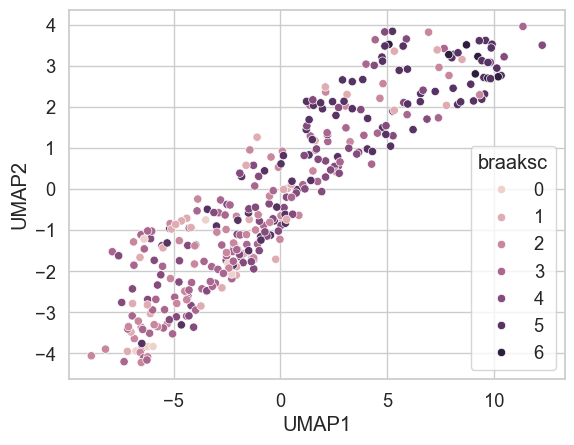

In [ ]:
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="braaksc")

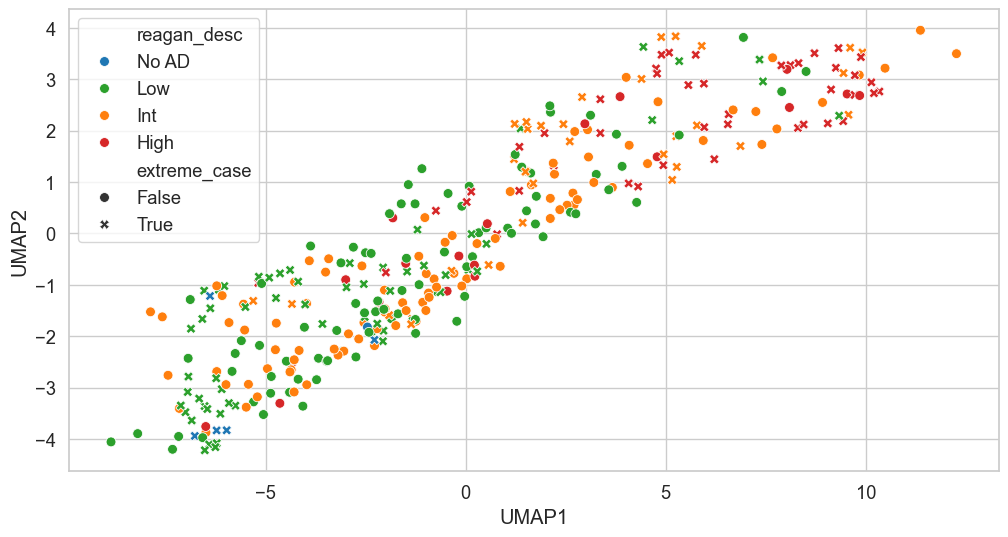

In [ ]:
BLUE = "#1f77b4"
ORANGE = "#ff7f0e"
GREEN = "#2ca02c"
RED = "#d62728"

hue_order = ["No AD", "Low", "Int", "High"]
ddata.obs["extreme_case"] = ddata.obs["wang_label"] != "Other" 
palette = sns.color_palette([BLUE, GREEN, ORANGE, RED])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", 
                hue="reagan_desc", s=50, palette=palette, hue_order=hue_order,
                style="extreme_case", style_order=[False, True])
plt.show()

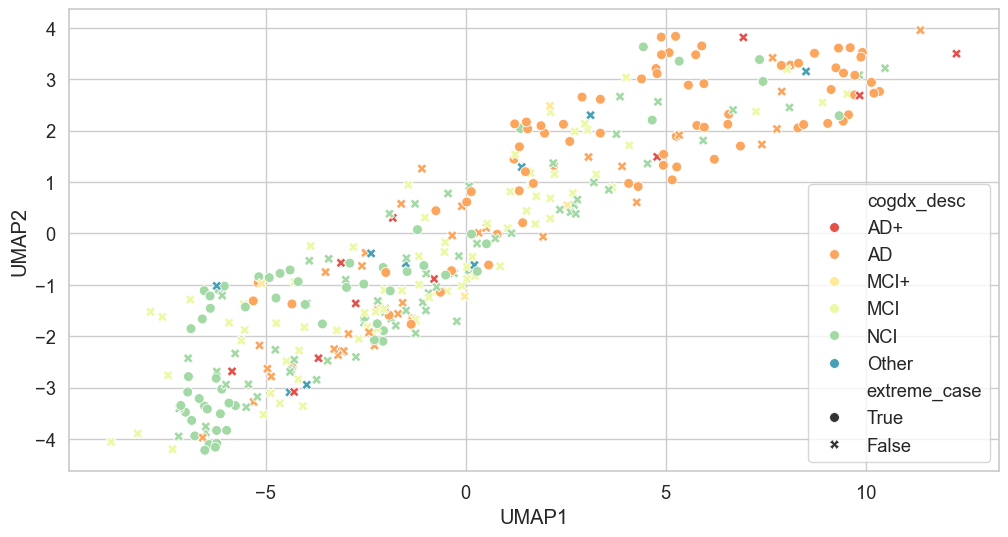

In [ ]:
hue_order = ["Other", "NCI", "MCI", "MCI+", "AD", "AD+"][::-1]
# hue_order = ["NCI", "MCI", "AD"][::-1]
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="cogdx_desc", s=MARKER_SIZE,
                palette="Spectral", hue_order=hue_order, style="extreme_case", 
                legend="full", style_order=[True, False])
plt.show()

<Axes: xlabel='y_pred', ylabel='Count'>

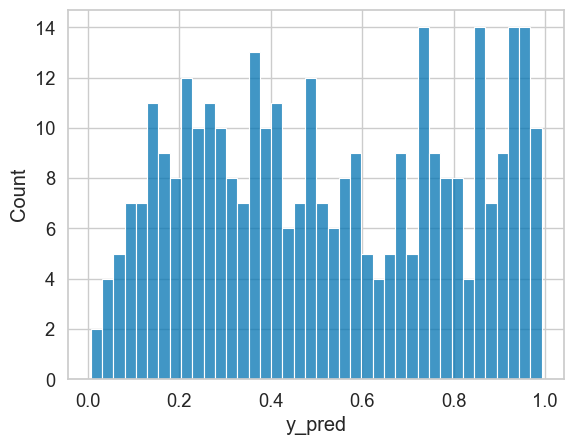

In [ ]:
sns.histplot(ddata.obs["y_pred"], bins=40)

### Confounding effect in msex metadata

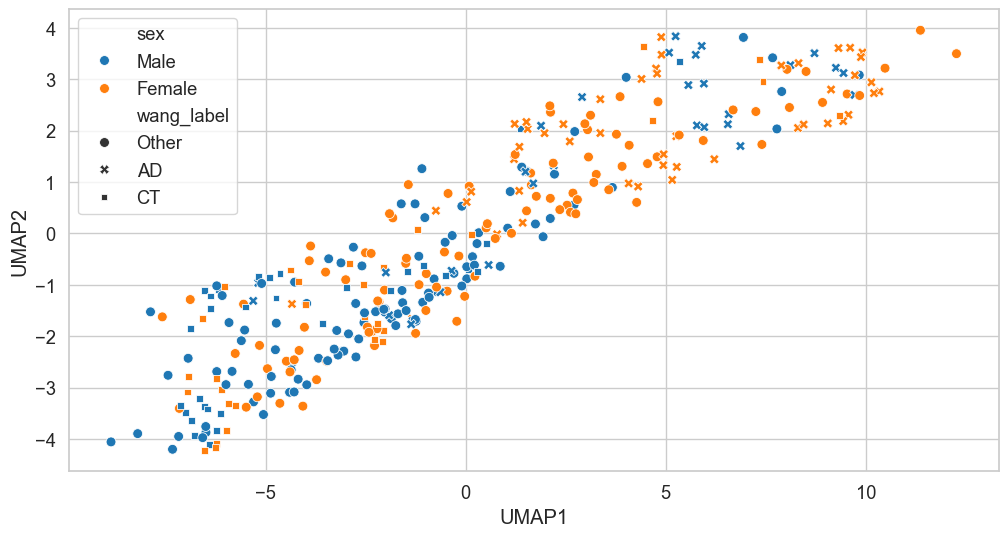

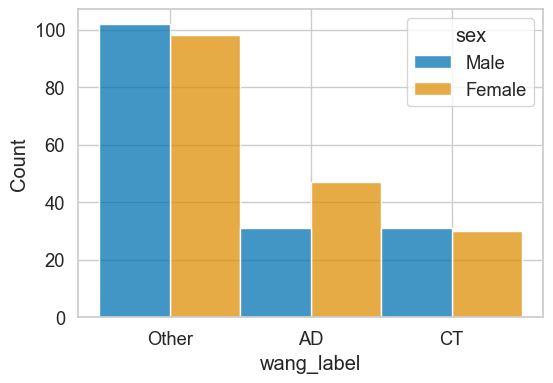

In [ ]:
# UMAP color by sex and wang_label
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="sex", style="wang_label", s=MARKER_SIZE, palette="tab10")
plt.show()

# Show distribution per class in histplot
plt.figure(figsize=(6, 4))
sns.histplot(data=ddata.obs, x="wang_label", hue="sex", multiple="dodge")
plt.show()

In [ ]:
ddata.obs["y_pred_hard"] = (ddata.obs["y_pred"] > 0.5).map({True: 1, False: 0})


Mean ypred: M=0.443, F=0.603


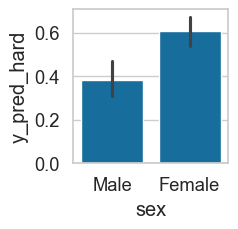

In [ ]:
# Mean prediction per F/M
y_pred_mean_m = ddata[ddata.obs["sex"] == "Male"].obs["y_pred"].mean()
y_pred_mean_f = ddata[ddata.obs["sex"] == "Female"].obs["y_pred"].mean()

print(f"Mean ypred: M={y_pred_mean_m:.3f}, F={y_pred_mean_f:.3f}")

fig, ax = plt.subplots(figsize=(2, 2))
sns.barplot(ddata.obs, y="y_pred_hard", x="sex", ax=ax)
plt.show()

In [ ]:
# drop train
ddata_notrain = ddata[ddata.obs["cv_set"] != "train"].copy()
print(ddata_notrain)

ddata_notrain.obs["wang_label"].value_counts()

AnnData object with n_obs × n_vars = 227 × 128
    obs: 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl', 'cancer_bl', 'diabetes_sr_rx_bl', 'headinjrloc_bl', 'thyroid_bl', 'chf_bl

wang_label
Other    200
AD        15
CT        12
Name: count, dtype: int64

In [ ]:
# Predict sex from embeddings:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = ddata_notrain.X
y = ddata_notrain.obs["msex"]

clf = LogisticRegression(max_iter=1000)
np.mean(cross_val_score(clf, X, y, cv=5))

0.9781642512077294

## Check other possible covariates

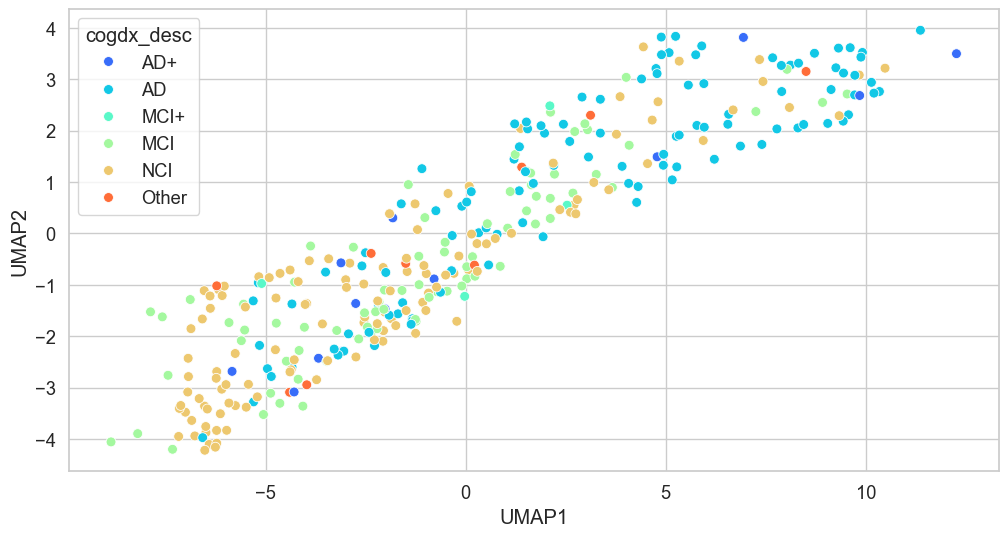

In [ ]:
plt.figure(figsize=(12, 6))
hue_order = ["AD+", "AD", "MCI+", "MCI", "NCI", "Other"]
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="cogdx_desc", s=MARKER_SIZE, palette="rainbow", hue_order=hue_order)
plt.show()

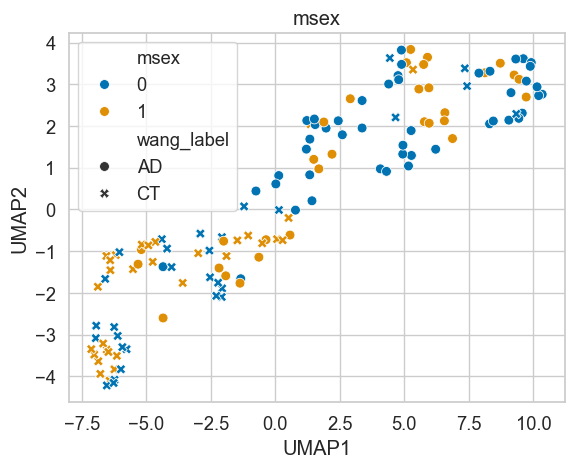

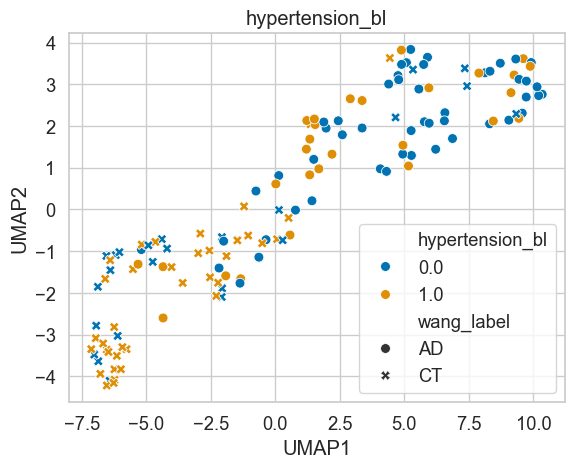

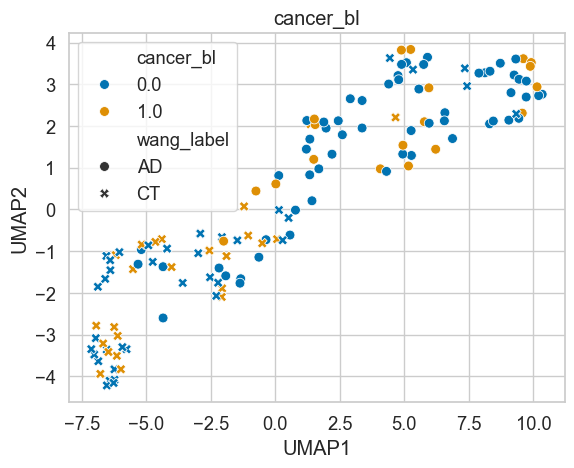

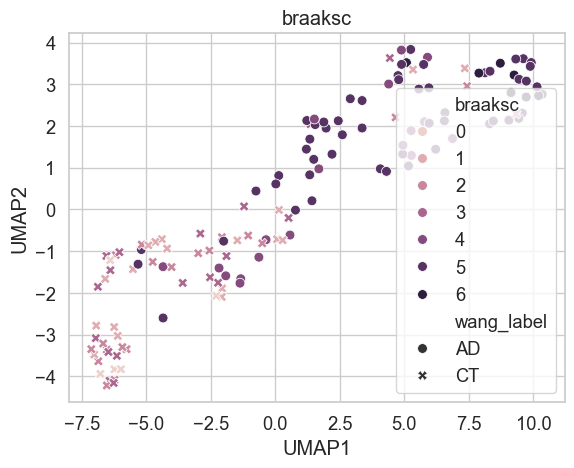

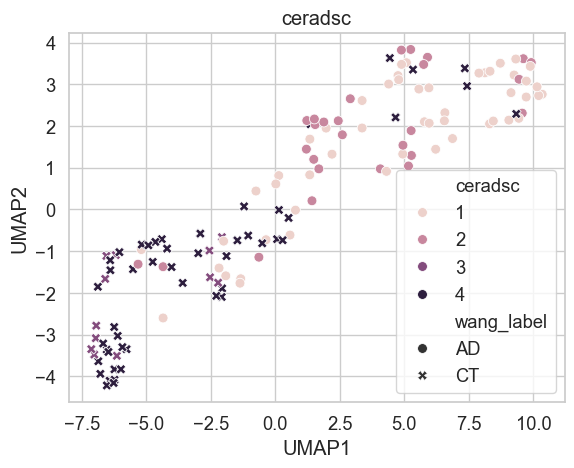

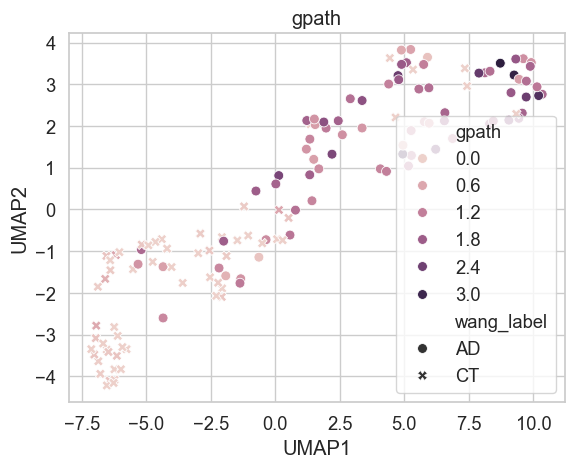

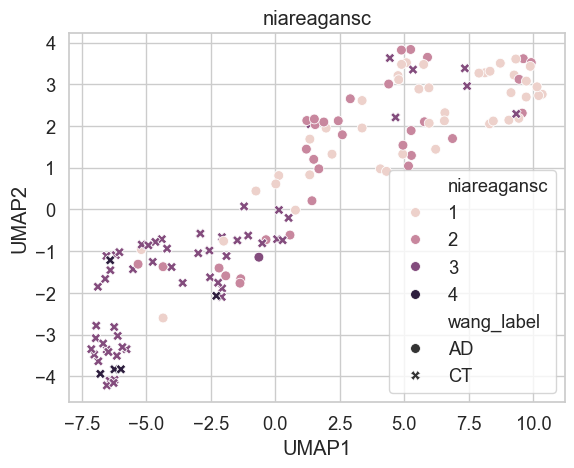

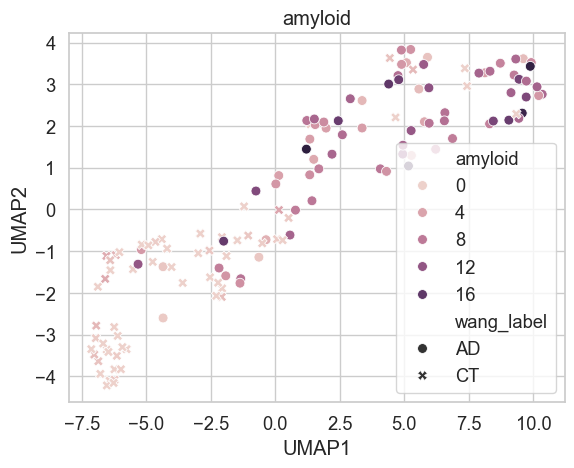

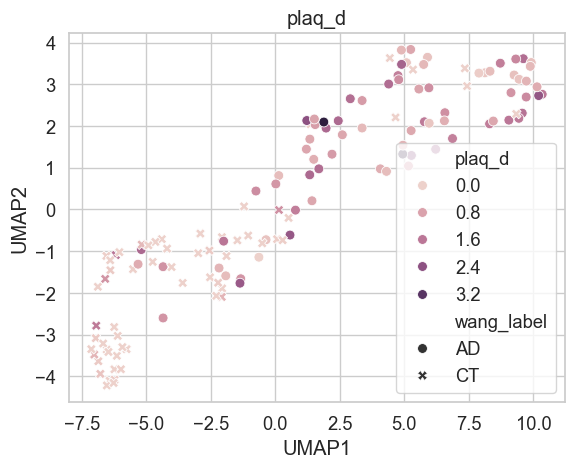

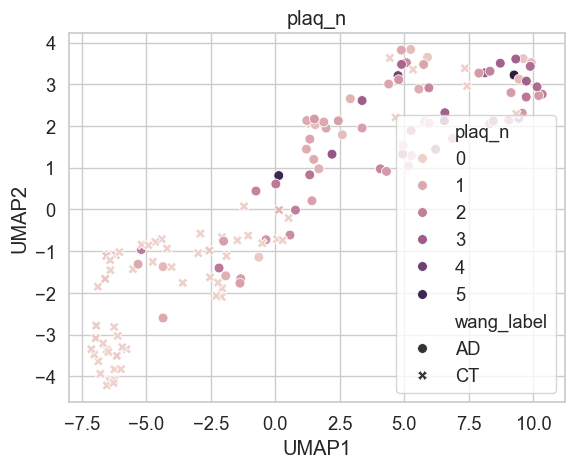

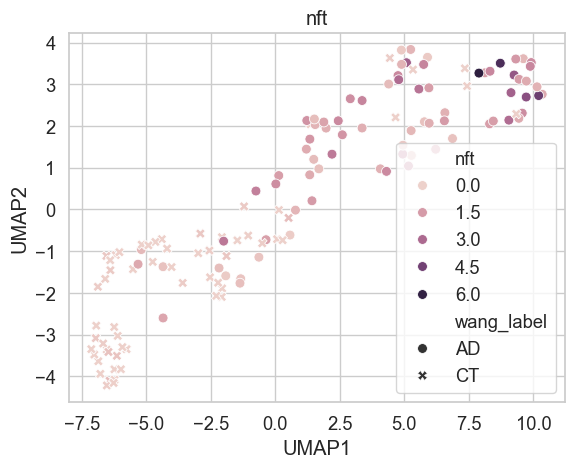

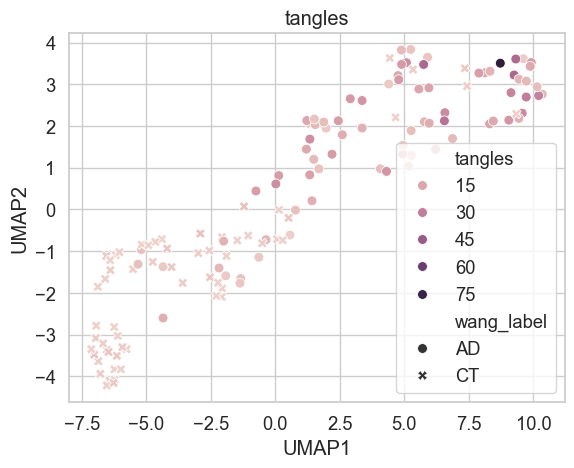

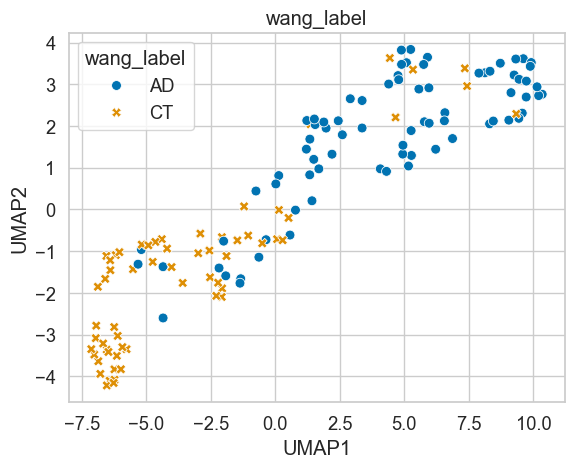

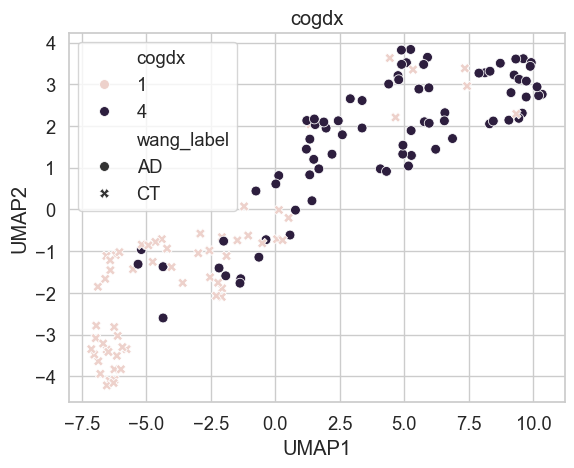

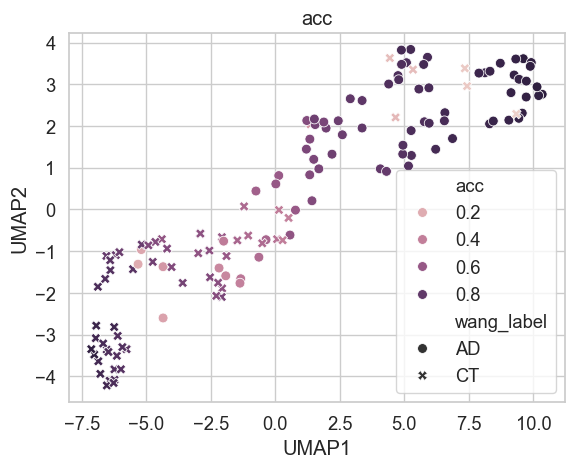

In [ ]:
for col in [
    "msex",
    "hypertension_bl",
    "cancer_bl",
    "braaksc",
    "ceradsc",
    "gpath",
    "niareagansc",
    "amyloid",
    "plaq_d",
    "plaq_n",
    "nft",
    "tangles",
    "wang_label",
    "cogdx",
    "acc"
]:
    plt.figure()
    sns.scatterplot(data=ddata_noint.obs, x="UMAP1", y="UMAP2", hue=col, s=MARKER_SIZE, style="wang_label")
    plt.title(col)
    plt.show()